# Durable Consumption Model

In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass
from consav import linear_interp
from consav.grids import nonlinspace # grids

import numba as nb
nb.set_num_threads(8)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [11]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

numba precompiled in 19.4 secs
 t = 54 solved in 0.1 secs
  w computed in 9.1 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 53 solved in 9.3 secs
  w computed in 9.0 secs
  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 52 solved in 18.5 secs
  w computed in 9.1 secs
  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 51 solved in 27.8 secs
  w computed in 9.1 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 50 solved in 37.1 secs
  w computed in 9.1 secs
  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 49 solved in 46.5 secs
  w computed in 9.3 secs
  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 48 solved in 56.0 secs
  w computed in 9.3 secs
  solved keeper problem in 0.2 secs
  solved adjuster problem in 0.0 secs
 t = 47 solved in 65.5 secs
  w computed in 9.2 secs
  solved keeper problem in 0.

**Plot** interactive decision functions:

In [19]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

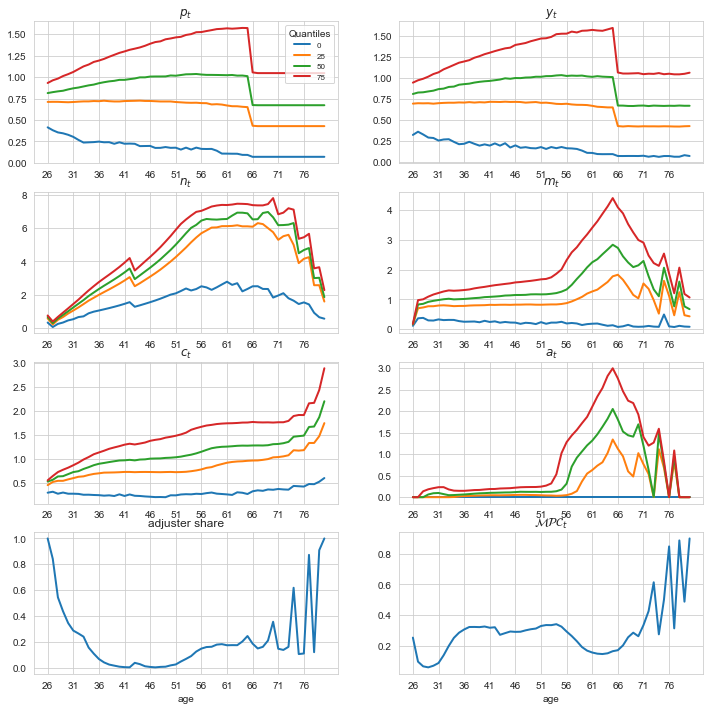

In [10]:
model_negm.lifecycle(deciles=True)

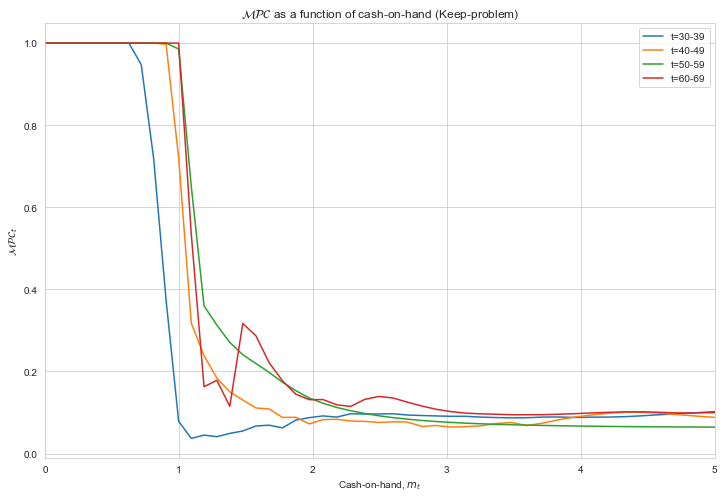

In [9]:
model_negm.mpc_over_cash_on_hand()

In [22]:
model_negm.sim.mpc.mean()

0.25618771143195923

## Sensitivity check - interest rate spread

In [ ]:
Rs = [1.01, 1.02, 1.03]
spreads = [0.04, 0.05, 0.06, 0.07]
for R,spread in zip(Rs,spreads):
    model = DurableConsumptionModelClass(
        name='example_negm',
        par={
            'solmethod':'negm',
            'R': R,
            'spread':spread,
            'do_print':False})
    model.precompile_numba() # solve with very coarse grids
    model.solve()
    model.simulate()
    print(f"For (R={R:.2f}, Rh={R+spread:.2f}, spread={spread:.2f}): Mean MPC = {model.sim.mpc.mean():.2f}")

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [ ]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':True})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

**Plot** interactive decision functions:

In [ ]:
model_nvfi.decision_functions()

**Plot** life-cycle profiles:

In [ ]:
model_nvfi.lifecycle(deciles=True)

# Compare life-cycles from NVFI and NEGM

In [ ]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [ ]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

In [ ]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')